In [1]:
#Importing necessary packages

import geopandas as gpd
import pandas as pd
import matplotlib.pylab as plt
import fiona
import osmnx as ox
import networkx as nx
from geopy import Nominatim

%matplotlib inline

In [2]:
areas = ['Santa monica, Los Angeles County, California',
         'Boulder, Colorado, USA',
         'Manhattan, NY, USA']

## Construct a function to smartly download the graph

In [3]:
def Download_graph(query, network_type='drive', timeout=10, return_n=False, draw=True):
    """
    Use osmnx.graph_from_place to download street network, 
    automatically select the result that return a polygon and visualize it.
    
    Parameters
    ----------
    query : string or dict or list
        the place(s) to geocode/download data for
    network_type : string
        what type of street network to get
    timeout : int
        the timeout interval for requests and to pass to API
    return_n : bool
        if True, return which result is selected
    draw : bool
        if True, plot the polygon
        
    Returns
    -------
    networkx multidigraph or networkx multidigraph and which_result as a tuple
    """
    
    n = 1
    while True:
        try:
            nw = ox.graph_from_place(query=query, network_type=network_type, timeout=timeout, which_result=n)
            break
        except ValueError:
            n += 1
    nw_p = ox.project_graph(nw)
    
    if draw:
        print(nx.info(nw_p))
        ox.plot_graph(nw_p, fig_height=10)
    
    if return_n:
        return (nw_p, n)
    else:
        return nw_p

Name: Santa monica, Los Angeles County, California_UTM
Type: MultiDiGraph
Number of nodes: 1193
Number of edges: 3515
Average in degree:   2.9464
Average out degree:   2.9464


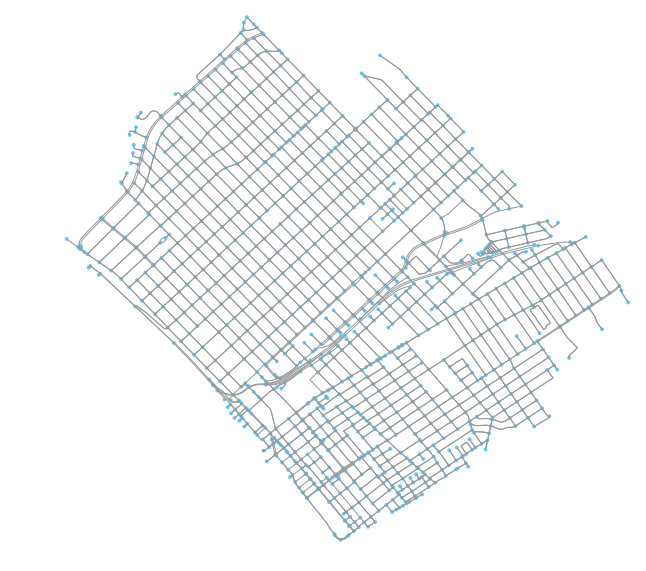

Name: Boulder, Colorado, USA_UTM
Type: MultiDiGraph
Number of nodes: 3118
Number of edges: 8031
Average in degree:   2.5757
Average out degree:   2.5757


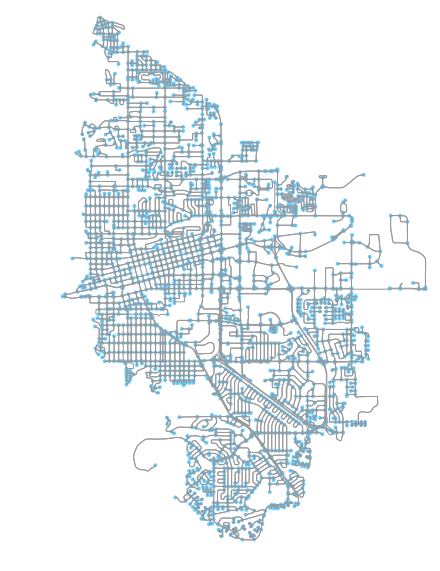

Name: Manhattan, NY, USA_UTM
Type: MultiDiGraph
Number of nodes: 4445
Number of edges: 9637
Average in degree:   2.1681
Average out degree:   2.1681


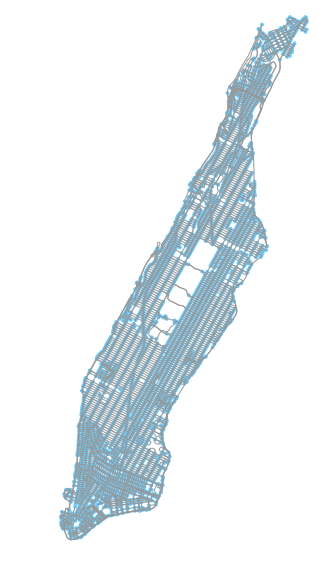

In [5]:
nw = list(map(Download_graph, areas))

## Edge cases on road identification

Take 'Santa Monica 2nd Street' as examples

In [6]:
(gdf_nodes, gdf_edges) = ox.save_load.graph_to_gdfs(nw[0])

In [9]:
gdf_edges[gdf_edges.name == '2nd Street'].head()

,access,bridge,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,ref,tunnel,u,v
569,NaN,NaN,LINESTRING (361910.2880989344 3764666.75573246...,tertiary,0,3,207.454591,30 mph,2nd Street,False,"[397532369, 397532371, 397532372]",NaN,NaN,122738694,123244029
570,NaN,NaN,LINESTRING (361910.2880989344 3764666.75573246...,tertiary,0,3,207.161263,30 mph,2nd Street,False,"[398340938, 398340939, 398340940, 398340941, 1...",NaN,NaN,122738694,5052303028
693,NaN,NaN,LINESTRING (361047.2272770241 3765577.78041154...,residential,0,NaN,208.028589,25 mph,2nd Street,False,"[508402603, 508402733]",NaN,NaN,122767024,122790220
694,NaN,NaN,LINESTRING (361047.2272770241 3765577.78041154...,residential,0,NaN,207.655720,25 mph,2nd Street,False,"[508403992, 13389034]",NaN,NaN,122767024,122773806
860,NaN,NaN,LINESTRING (360904.3513206288 3765728.36618790...,residential,0,NaN,207.655720,25 mph,2nd Street,False,"[508403992, 13389034]",NaN,NaN,122773806,122767024


In [7]:
gdf_edges.loc[21:21]

,access,bridge,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,ref,tunnel,u,v
21,NaN,NaN,LINESTRING (363456.6926390323 3762927.97478536...,residential,0,NaN,67.412809,25 mph,"[2nd Street, Hampton Drive]",False,"[13405948, 274676231]",NaN,NaN,122476483,123089324


The two black lines are both called '2nd Street'. The red line is '[2nd Street, Hampton Drive]'. This case shows that the streets with same name can be different road and some street assigned with two or more road names. 

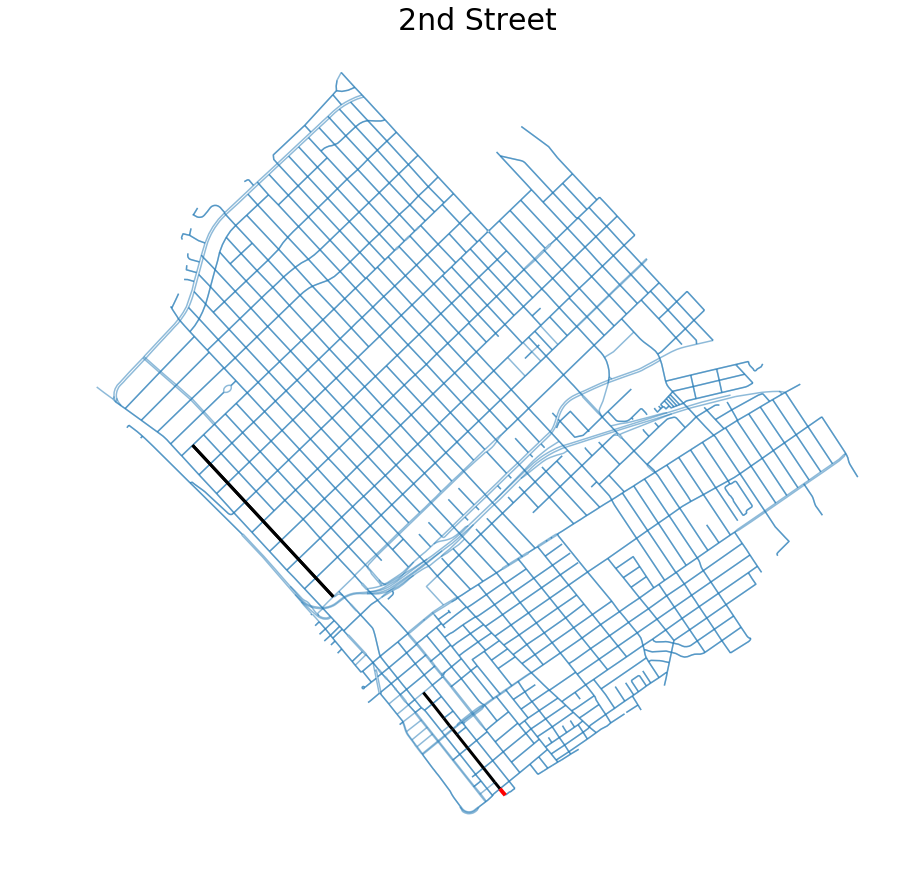

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
gdf_edges.plot(ax=ax, alpha=0.5)
gdf_edges[gdf_edges.name == '2nd Street'].plot(ax=ax, color='black', linewidth=3)
gdf_edges.loc[21:21].plot(ax=ax, color='red', linewidth=4)
ax.set_title('2nd Street', fontsize=30)
ax.set_axis_off()

We are working on an algorithm that identify independent roads and their starting and ending nodes.